In [1]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_fscore_support, roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# imbalanced-learn (for SMOTE + safe ML pipeline)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

RNG = 42
np.random.seed(RNG)
pd.set_option("display.max_columns", 200)


In [3]:
# Tries typical Kaggle names; place the CSV(s) in the working directory first.
candidates = [
    "train.csv",                         # many Kaggle mirrors
    "loan.csv", "loans.csv",
    "loan_approval_dataset.csv",
    "LoanApprovalDataset.csv",
    "loan_approval.csv",
    "loan_approval_prediction.csv",
    "train_u6lujuX_CVtuZ9i.csv"         # classic AV dataset filename
]

found = None
for p in candidates:
    if os.path.exists(p):
        found = p
        break

if not found:
    raise FileNotFoundError(
        "Put the Kaggle loan dataset CSV here (e.g., train.csv or loan_approval_dataset.csv)."
    )

df = pd.read_csv(found)
print("Loaded file:", found, "| shape:", df.shape)
df.head()


Loaded file: loan_approval_dataset.csv | shape: (4269, 13)


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB
None
Missing ra

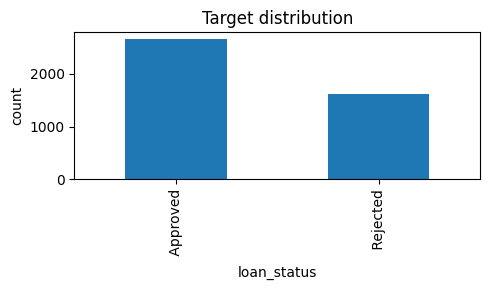

In [4]:
print(df.info())

# Standardize column names (lowercase, strip spaces)
df.columns = [c.strip().lower() for c in df.columns]

# Identify target column variants
target_candidates = ["loan_status", "status", "loan_approval_status", "approved", "loanstatus"]
y_col = None
for c in target_candidates:
    if c in df.columns:
        y_col = c
        break
if y_col is None:
    raise ValueError("Target column not found. Expected one of: " + ", ".join(target_candidates))

# Quick missingness check
missing = df.isna().mean().sort_values(ascending=False)
print("Missing rate (top 15):\n", missing.head(15))

# Class distribution
print("Class counts:\n", df[y_col].value_counts(dropna=False))
plt.figure(figsize=(5,3))
df[y_col].value_counts().plot(kind="bar")
plt.title("Target distribution")
plt.xlabel(y_col)
plt.ylabel("count")
plt.tight_layout()
plt.show()


In [6]:
y_raw = df[y_col].copy()

# Map common encodings to {0,1}
# Typical Kaggle: 'Y'/'N'. Some sets use 'Approved'/'Rejected', or 1/0 already.
mapping = {
    "y": 1, "yes": 1, "approved": 1, "1": 1, 1: 1, True: 1,
    "n": 0, "no": 0, "rejected": 0, "0": 0, 0: 0, False: 0
}
def map_target(v):
    if pd.isna(v): return np.nan
    s = str(v).strip().lower()
    return mapping.get(s, np.nan)

y = y_raw.apply(map_target)
if y.isna().any():
    # If some labels are still NaN, show unique values to fix mapping.
    print("Unique target values:", sorted(df[y_col].dropna().astype(str).str.lower().unique()))
    raise ValueError("Unmapped target labels. Extend mapping above if needed.")

# Drop target from features; drop obvious id columns if present
X = df.drop(columns=[y_col])
for id_like in ["loan_id", "id", "customer_id", "applicant_id"]:
    if id_like in X.columns:
        X = X.drop(columns=[id_like])

print("X shape:", X.shape, "| y positive rate:", y.mean().round(4))


X shape: (4269, 11) | y positive rate: 0.6222


In [7]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# Build OneHotEncoder with cross-version fallback (dense needed for SMOTE)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_pipe = Pipeline(steps=[("imp", SimpleImputer(strategy="median"))])
cat_pipe = Pipeline(steps=[("imp", SimpleImputer(strategy="most_frequent")),
                           ("ohe", ohe)])

pre = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop"
)

print(f"Numeric cols: {len(num_cols)} | Categorical cols: {len(cat_cols)}")


Numeric cols: 9 | Categorical cols: 2


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RNG
)
X_train.shape, X_test.shape, y_train.mean().round(4), y_test.mean().round(4)


((3415, 11), (854, 11), np.float64(0.6223), np.float64(0.6218))

In [9]:
def evaluate_binary(model, X_te, y_te, title="Model"):
    y_pred = model.predict(X_te)
    # Try proba for ROC-AUC; fallback to decision_function if needed
    try:
        y_score = model.predict_proba(X_te)[:,1]
    except Exception:
        try:
            y_score = model.decision_function(X_te)
        except Exception:
            y_score = None

    print(f"\n=== {title} ===")
    print(classification_report(y_te, y_pred, digits=4))

    cm = confusion_matrix(y_te, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    fig, ax = plt.subplots(figsize=(5,5))
    disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
    ax.set_title(f"{title} — Confusion Matrix")
    plt.tight_layout(); plt.show()

    p, r, f1, _ = precision_recall_fscore_support(y_te, y_pred, average="binary")
    auc = roc_auc_score(y_te, y_score) if y_score is not None else np.nan
    return {"model": title, "precision": p, "recall": r, "f1": f1, "roc_auc": auc}



=== Logistic (balanced) ===
              precision    recall  f1-score   support

           0     0.7419    0.7121    0.7267       323
           1     0.8290    0.8493    0.8391       531

    accuracy                         0.7974       854
   macro avg     0.7855    0.7807    0.7829       854
weighted avg     0.7961    0.7974    0.7966       854



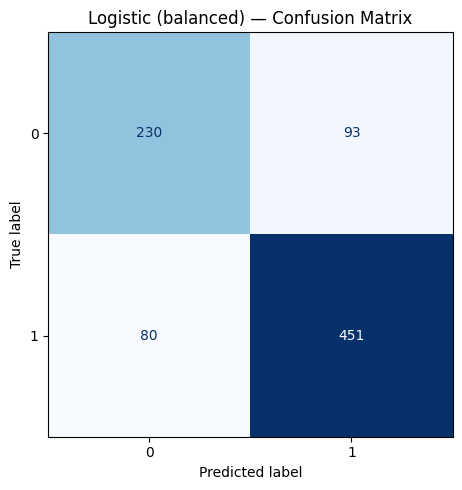

{'model': 'Logistic (balanced)',
 'precision': 0.8290441176470589,
 'recall': 0.8493408662900188,
 'f1': 0.8390697674418605,
 'roc_auc': np.float64(0.8652055529318479)}

In [10]:
log_reg = Pipeline(steps=[
    ("pre", pre),
    ("clf", LogisticRegression(
        solver="lbfgs", max_iter=2000, class_weight="balanced", random_state=RNG
    ))
])
log_reg.fit(X_train, y_train)
res_log = evaluate_binary(log_reg, X_test, y_test, title="Logistic (balanced)")
res_log



=== Decision Tree (balanced) ===
              precision    recall  f1-score   support

           0     0.9780    0.9628    0.9704       323
           1     0.9776    0.9868    0.9822       531

    accuracy                         0.9778       854
   macro avg     0.9778    0.9748    0.9763       854
weighted avg     0.9778    0.9778    0.9777       854



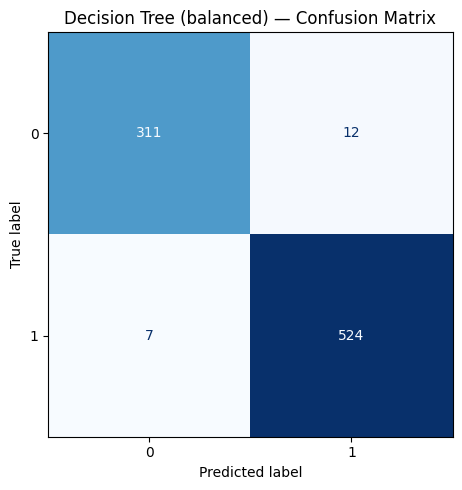

{'model': 'Decision Tree (balanced)',
 'precision': 0.9776119402985075,
 'recall': 0.9868173258003766,
 'f1': 0.9821930646672915,
 'roc_auc': np.float64(0.9748328115069995)}

In [11]:
dt = Pipeline(steps=[
    ("pre", pre),
    ("clf", DecisionTreeClassifier(
        max_depth=None, min_samples_split=2, class_weight="balanced", random_state=RNG
    ))
])
dt.fit(X_train, y_train)
res_dt = evaluate_binary(dt, X_test, y_test, title="Decision Tree (balanced)")
res_dt



=== SMOTE + Logistic ===
              precision    recall  f1-score   support

           0     0.7325    0.7121    0.7221       323
           1     0.8278    0.8418    0.8347       531

    accuracy                         0.7927       854
   macro avg     0.7801    0.7769    0.7784       854
weighted avg     0.7917    0.7927    0.7921       854



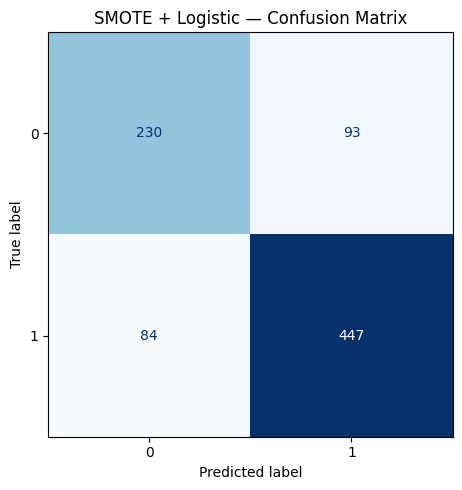

{'model': 'SMOTE + Logistic',
 'precision': 0.8277777777777777,
 'recall': 0.8418079096045198,
 'f1': 0.834733893557423,
 'roc_auc': np.float64(0.8640452910275023)}

In [12]:
smote_log = ImbPipeline(steps=[
    ("pre", pre),
    ("smote", SMOTE(random_state=RNG, k_neighbors=5)),
    ("clf", LogisticRegression(solver="lbfgs", max_iter=2000, random_state=RNG))
])
smote_log.fit(X_train, y_train)
res_smote_log = evaluate_binary(smote_log, X_test, y_test, title="SMOTE + Logistic")
res_smote_log



=== SMOTE + Decision Tree ===
              precision    recall  f1-score   support

           0     0.9752    0.9721    0.9736       323
           1     0.9831    0.9849    0.9840       531

    accuracy                         0.9801       854
   macro avg     0.9791    0.9785    0.9788       854
weighted avg     0.9801    0.9801    0.9801       854



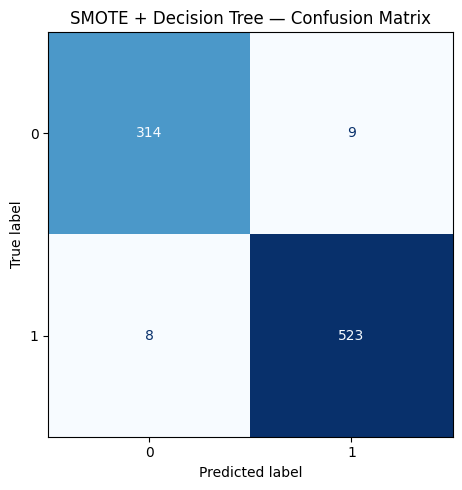

{'model': 'SMOTE + Decision Tree',
 'precision': 0.9830827067669173,
 'recall': 0.9849340866290018,
 'f1': 0.9840075258701787,
 'roc_auc': np.float64(0.9785351547696093)}

In [13]:
smote_dt = ImbPipeline(steps=[
    ("pre", pre),
    ("smote", SMOTE(random_state=RNG, k_neighbors=5)),
    ("clf", DecisionTreeClassifier(random_state=RNG))
])
smote_dt.fit(X_train, y_train)
res_smote_dt = evaluate_binary(smote_dt, X_test, y_test, title="SMOTE + Decision Tree")
res_smote_dt


In [14]:
summary = pd.DataFrame([
    res_log, res_dt, res_smote_log, res_smote_dt
]).sort_values("f1", ascending=False).reset_index(drop=True)
summary


,model,precision,recall,f1,roc_auc
0,SMOTE + Decision Tree,0.983083,0.984934,0.984008,0.978535
1,Decision Tree (balanced),0.977612,0.986817,0.982193,0.974833
2,Logistic (balanced),0.829044,0.849341,0.839070,0.865206
3,SMOTE + Logistic,0.827778,0.841808,0.834734,0.864045


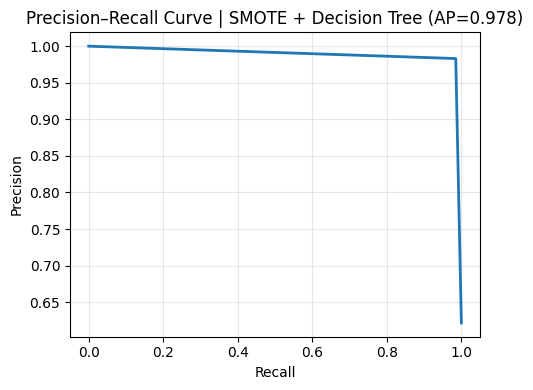

In [15]:
best_name = summary.loc[0, "model"]
best = {
    "Logistic (balanced)": log_reg,
    "Decision Tree (balanced)": dt,
    "SMOTE + Logistic": smote_log,
    "SMOTE + Decision Tree": smote_dt
}[best_name]

from sklearn.metrics import precision_recall_curve, average_precision_score
y_score = best.predict_proba(X_test)[:,1]
prec, rec, thr = precision_recall_curve(y_test, y_score)
ap = average_precision_score(y_test, y_score)

plt.figure(figsize=(5,4))
plt.plot(rec, prec, lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve | {best_name} (AP={ap:.3f})")
plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()


In [16]:
# Saves preprocessor+model pipeline for reuse
import joblib
joblib.dump(best, "loan_approval_best_model.joblib")
print("Saved: loan_approval_best_model.joblib")


Saved: loan_approval_best_model.joblib
